# RGI17 (Southern Andes)

F. Maussion

New inventory compiled by Philipp and Frank based on the new Chile and argentina inventories.

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 17

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '17_rgi60_SouthernAndes.zip')

# Support data dir
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [3]:
# Read L2 files from GLIMS
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, df_class = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
97,16,182.7,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
98,54,739.7,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
99,21,1015.9,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
100,25,862.0,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
101,13,1165.2,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
478,1,6.2,Zenteno,Zenteno,2007,"Chilean glaciers, between -18 and -56 degrees ...",2005,2005,2005
510,7,63.3,Schnirch,Schneider,2008,Antarctic Peninsula,1998,1998,1998
511,8,15.4,Schnirch,Schneider,2008,Antarctic Peninsula,1998,1998,1998
512,12,86.8,Schnirch,Schneider,2008,Antarctic Peninsula,1998,1998,1998


Notes based on manual observations:
- 510 to 516 are a few outlines in Patagonia
- 592 is RGI, looks spatially complete.
- 700 is the Argentina glacier inventory. 708 is an update of 75 of its outlines, for reasons quite unclear to me (the outlines are still in 700)
- 730 is the Chilan glacier inventory
- 764 is the CL and AR inventory merged

both 700/708 and 720 have the same issues (rock glaciers) as for RGI16. Furthermore, the Argentina / Chile border makes both inventories pretty much useless as is. This is why 764 was created.

In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_sel_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_sel_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_sel_inventories']))

## Outline selection 

In [6]:
rgi7 = shp.loc[shp.subm_id.isin([764])].copy()

In [7]:
# Size filter?
needs_size_filter(rgi7)

True

In [8]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

30851
30701


In [9]:
rgi7['is_rgi6'] = False

### Some sanity checks 

In [10]:
dupes = find_duplicates(rgi7)

Potential duplicates: 2


In [11]:
rgi7 = rgi7.loc[~rgi7.anlys_id.isin([dupes.anlys_id.iloc[1]])]
dupes = find_duplicates(rgi7)

Seems Okay!


In [12]:
rgi7 = correct_geoms(rgi7)

Found 708 invalid geometries out of 30700. Correcting...
High correction: 947636. Area diff: -944.1053043628344 m2 (-0.1617%) Smaller than 0.1 km2. Ignoring.
After correction, 0 geometries are still invalid.
Area changed by -945.7 m2 (-0.0000%)


In [13]:
needs_size_filter(rgi7)

False

In [14]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
764,30700,30700


In [15]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area
        orphan_f = orphan_f.loc[orphan_f.subm_id.isin(rgi7.subm_id.unique()[check])]

In [16]:
orphan_f['area'].sum() * 1e-6

20.164785018848278

### Plots 

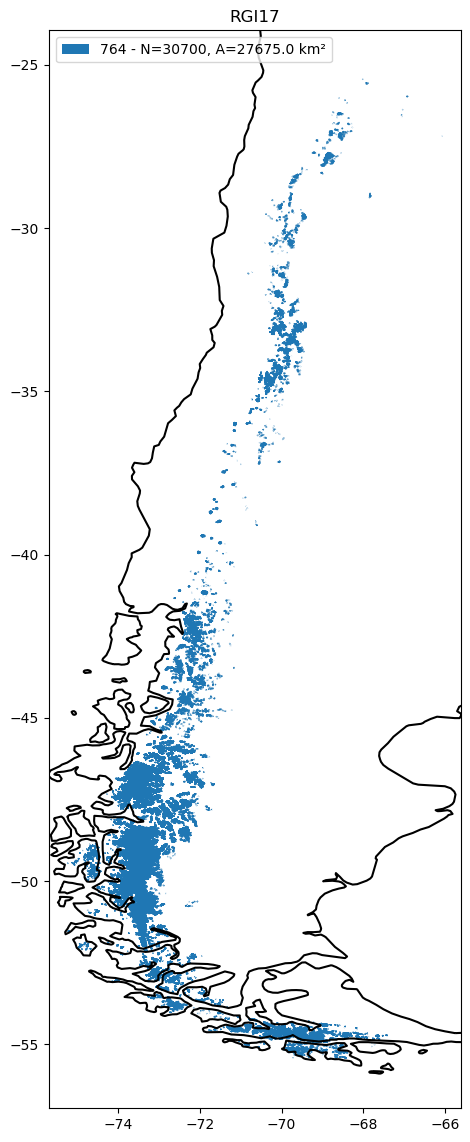

In [17]:
plot_map(rgi7, reg, aspect=0.8, loc='upper left')

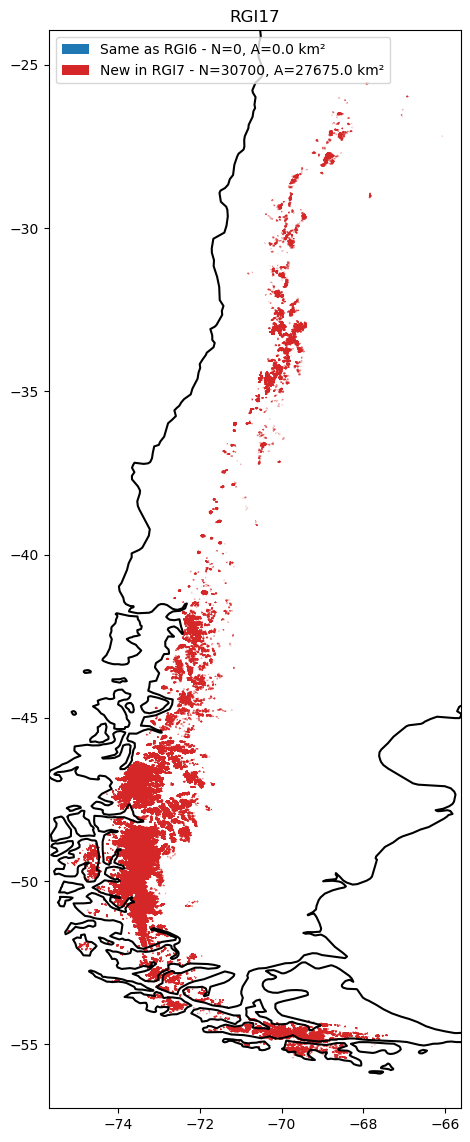

In [18]:
plot_map(rgi7, reg, aspect=0.8, loc='upper left', is_rgi6=True)

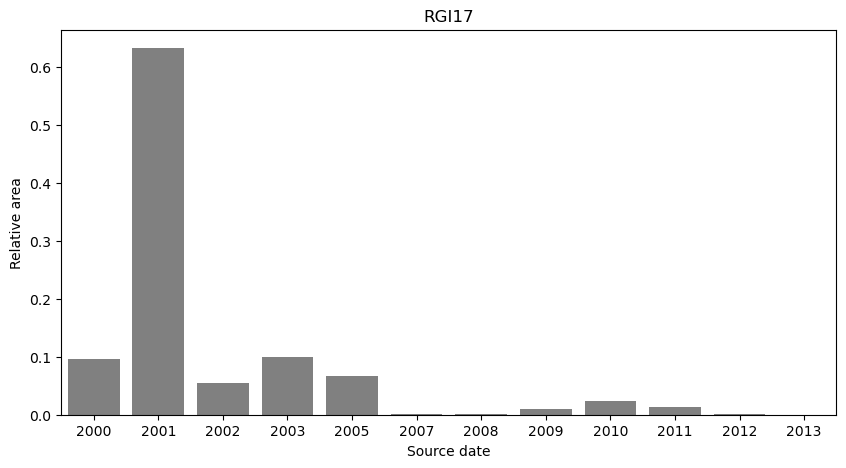

In [19]:
plot_date_hist(rgi7, reg)

### Text for github

In [20]:
fgh = sdf.T
fgh

subm_id,764
N,30700
A,27675.0
analysts,"Paul, Rastner"
submitters,Paul
release_date,2022
geog_area,Various (GlobGlacier)
src_date_mode,2001
src_date_min,2000
src_date_max,2013


In [21]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 764                   |
|:--------------|:----------------------|
| N             | 30700                 |
| A             | 27675.0               |
| analysts      | Paul, Rastner         |
| submitters    | Paul                  |
| release_date  | 2022                  |
| geog_area     | Various (GlobGlacier) |
| src_date_mode | 2001                  |
| src_date_min  | 2000                  |
| src_date_max  | 2013                  |


## Write out and tar 

In [22]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI17/
RGI17/RGI17.shp
RGI17/RGI17.dbf
RGI17/RGI17.prj
RGI17/RGI17.cpg
RGI17/RGI17.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI17.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI17'], returncode=0)


## Consistency check with RGI6 (differences are expected)

In [43]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [44]:
len(rgi7), len(rgi6)

(30700, 15908)

Test the areas:

In [45]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 

In [46]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 27675.049185551605
Area RGI6 (km2) 29429.170810136457
diff areas RGI6 - RGI7 computed by us (km2) 1754.121624584854


## Check with original file

The [RGI17_workaround.ipynb](RGI17_workaround.ipynb) checks the file submitted by Phil withouth the GLIMS step. It is a good double check on GLIMS I think:

In [47]:
rgi7o = gpd.read_file('tar://' + os.path.join(support_dir, 'RGI17_self_made.tar.gz/RGI17/RGI17.shp'))

In [48]:
print('N RGI7a (km2)', len(rgi7))
print('N ref (km2)', len(rgi7o))

N RGI7a (km2) 30700
N ref (km2) 30700


In [49]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area ref (km2)', rgi7o['area'].sum() * 1e-6)
print('diff areas ref - RGI7 computed by us (km2)', (rgi7o['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 27675.049185551605
Area ref (km2) 27675.049540949774
diff areas ref - RGI7 computed by us (km2) 0.0003553981704711914
